<a href="https://colab.research.google.com/github/adamzki99/nlp-zlatan/blob/feature%2Fall-MiniLM-L6-v2-implementation/nlp_zlatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia

/content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia


# all-MiniLM-L6-v2

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 

In [3]:
import json

with open('data.json', 'r') as file:
    json_data = file.read()
    data = json.loads(json_data)

print('Datatype:', type(data))

Datatype: <class 'list'>


In [4]:
data[0]['dialog'][0].keys()

dict_keys(['speaker', 'text', 'checked_sentence', 'checked_passage', 'retrieved_passages', 'retrieved_topics'])

In [5]:
import pandas as pd

data_extract = {
    "chosen_topic": [],
    "speaker_passage": [],
    "checked_sentence": [],
    "chosen_topic_passage": []
}

for i, conversation in enumerate(data):

  for j, dialog in enumerate(conversation['dialog']):    

    if "Wizard" in dialog['speaker']:

      checked_sentence = list(dialog['checked_sentence'].values())
      
      if "no_passages_used" not in checked_sentence:
      
        data_extract['chosen_topic'].append(conversation['chosen_topic'])
        data_extract['speaker_passage'].append(dialog['text'])
        data_extract['checked_sentence'].append(checked_sentence)
        data_extract['chosen_topic_passage'].append(conversation['chosen_topic_passage'])

extact_df = pd.DataFrame(data_extract)

extact_df

,chosen_topic,speaker_passage,checked_sentence,chosen_topic_passage
0,Science fiction,I think science fiction is an amazing genre fo...,[Science fiction (often shortened to SF or sci...,[Science fiction (often shortened to SF or sci...
1,Science fiction,Awesome! I really love how sci-fi storytellers...,[Science fiction films have often been used to...,[Science fiction (often shortened to SF or sci...
2,Science fiction,"It's not quite sci-fi, but my favorite version...",[The central premise for these stories oftenti...,[Science fiction (often shortened to SF or sci...
3,Science fiction,If you really want a look at the potential neg...,[Science fiction often explores the potential ...,[Science fiction (often shortened to SF or sci...
4,Internet access,No I could not! I couldn't imagine living when...,"[Internet access was once rare, but has grown ...",[Internet access is the ability of individuals...
...,...,...,...,...
94659,Skiing,I knew skiing was a winter sport but I never t...,"[Skiing can be a means of transport, a recreat...","[Skiing can be a means of transport, a recreat..."
94660,Skiing,"It has a history of almost five millennia, so ...",[Skiing has a history of almost five millennia.],"[Skiing can be a means of transport, a recreat..."
94661,Skiing,It seems that it may also have been practiced ...,[Although modern skiing has evolved from begin...,"[Skiing can be a means of transport, a recreat..."
94662,Skiing,Seems early skiers used one long pole or a spe...,[Early skiers used one long pole or spear.],"[Skiing can be a means of transport, a recreat..."


In [6]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00


In [7]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In [8]:
selected_sentences = []
selected_conversation_topics = []

for c, row in extact_df.sample(1000).iterrows():
  
  selected_conversation_topics.append(row['chosen_topic'])

  for resp in row['checked_sentence']:
    pair = (row['speaker_passage'], resp)
    selected_sentences.append(pair)


#selected_sentences[::1]

In order for testing the implementation later, we create a copy of the data that was used for training.

In [9]:
implementation_testing_sentences = selected_sentences

Back to training the model...

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# Move model to GPU
model.to(device)

cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

## Using mean-pooling

We are using mean-pooling to aggregate the sentence embeddings into a vector representation that aims to capture the meaning of the sentence. This is performed by averaging the embeddings dimensions.

By also applying the attention mask wich is provided with the model, we are able improve the **accuracy** of the averaging. This is becase the function wont be taking into acount the words that wont provide usefull information, e.g. stop-words.

In [11]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [12]:
def perform_embedding(documents:list, device, model):

  encoded_documents = tokenizer(documents, padding=True, truncation=True, return_tensors='pt')

  encoded_documents.to(device)
  with torch.no_grad():
      model_output_documents = model(**encoded_documents)

  # Perform pooling
  embedding = mean_pooling(model_output_documents, encoded_documents['attention_mask'])

  # Normalize embedding
  #embedding = F.normalize(model_output_message, p=2, dim=1)

  return embedding

In [13]:
sentence_embeddings = perform_embedding(documents = selected_sentences, device = device, model = model)

## Visualizing Cluster with Hypertools

In [14]:
%pip install hypertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=982f786f35dad4237e2007a0e66c0a04050815820851cdbbfe8e3ff9b273cc3f
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=733826df77bbe795d0c0779d1b50f5671860398cb825407f7666f4b7a692fa7a
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


Number of clusters: 558


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hypertools/plot/plot.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwargs[kwarg]=np.array(kwargs[kwarg])


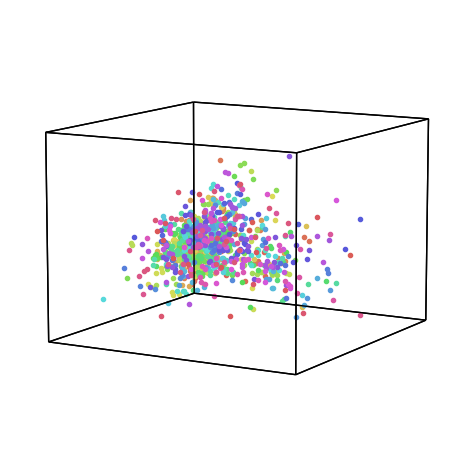

In [15]:
import hypertools as hyp

n_clusters = len(set(selected_conversation_topics))

print("Number of clusters:", n_clusters)

hyp.plot(sentence_embeddings.cpu().detach().numpy(), '.', n_clusters = n_clusters)

## Model usage

In [16]:
%pip install hnswlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.7.0-cp310-cp310-linux_x86_64.whl size=2119779 sha256=c6c40f0bfa8107b4715dd4a6bc08e5465cd795f64ff4d724e3f6f97a02eb85e3
  Stored in directory: /root/.cache/pip/wheels/8a/ae/ec/235a682e0041fbaeee389843670581ec6c66872db856dfa9a4
Successfully built hnswlib


In [17]:
import hnswlib

# Create the HNSW index
index = hnswlib.Index(space='l2', dim=sentence_embeddings.shape[1])
index.init_index(max_elements=len(sentence_embeddings), ef_construction=200, M=16)

# Add sentence embeddings to the index
index.add_items(sentence_embeddings.cpu().numpy())

In [18]:
# Get message
random_message = list(extact_df.sample(1).to_dict()['speaker_passage'].values())[0]
message = [random_message]

message

['I also cross with public health workers and collborate with them on issues like waterborne diseases.']

In [19]:
# Perform a similarity search
def search_embeddings(query:str, k, device, model):

  query_embedding = perform_embedding(documents=query, device=device, model=model)

  indexes, distances = index.knn_query(query_embedding.cpu(), k=k)

  return indexes[0], distances, query_embedding

In [20]:

indexes, distances, query_embedding = search_embeddings(query=message, k=10, device=device, model=model)

k = 10  # Number of closest neighbors to retrieve

print(indexes)

[ 61 371 475 583 810 416 978 355 505 454]


In [21]:
query_subset = []

for i, ind in enumerate(indexes):
  print("Distance:", distances[0][i], "\t", selected_sentences[ind][1])
  query_subset.append(selected_sentences[ind])

Distance: 21.394382 	 Orthopedic surgeons use both surgical and nonsurgical means to treat musculoskeletal trauma, spine diseases, sports injuries, degenerative diseases, infections, tumors, and congenital disorders.
Distance: 22.461964 	 A paramedic is a healthcare professional, predominantly in the pre-hospital and out-of-hospital environment, and working mainly as part of emergency medical services (EMS), such as on an ambulance.
Distance: 22.579529 	 Obesity increases the likelihood of various diseases and conditions, particularly cardiovascular diseases, type 2 diabetes, obstructive sleep apnea, certain types of cancer, osteoarthritis and depression.
Distance: 22.858353 	 Many nurses provide care within the ordering scope of physicians, and this traditional role has shaped the public image of nurses as care providers.
Distance: 22.90531 	 Risk factors include having an older parent, a family history of the condition, and certain genetic conditions.
Distance: 22.937214 	 Security g

## Looking at the result

In [22]:
selected_sentences_embedding = perform_embedding(documents=query_subset, device=device, model=model)

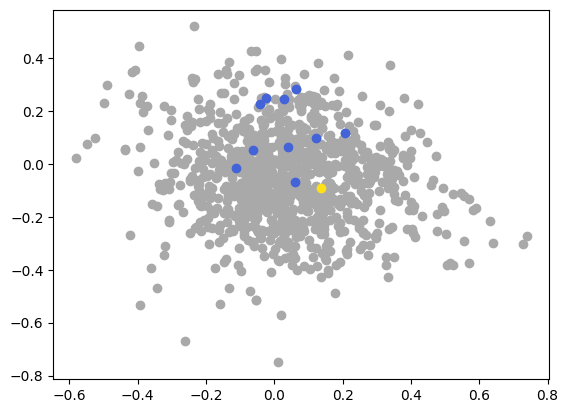

In [23]:
import matplotlib.pyplot as plt

plt.scatter(sentence_embeddings.cpu()[:,0] , sentence_embeddings.cpu()[:,1], c = '#a9a9a9')
plt.scatter(selected_sentences_embedding.cpu()[:,0] , selected_sentences_embedding.cpu()[:,1], c = '#4363d8')
plt.scatter(query_embedding.cpu()[:,0] , query_embedding.cpu()[:,1], color = '#ffe119')
plt.show()

## Testing the model

As we want the model to act as a vector-database we expect it to find the correct passage with the input that was used during training.

In [29]:
score = 0

for _, sentence_pair in enumerate(implementation_testing_sentences):

  indexes, distances, query_embedding = search_embeddings(query=sentence_pair[0], k=1, device=device, model=model)

  results = []
  for _, i in enumerate(indexes):
    results.append(selected_sentences[i])
  

  if sentence_pair in results:
    score += 1
  
print("Accuracy:", score/len(implementation_testing_sentences)*100, "%")

Accuracy: 96.37826961770624 %


## Finding the correct Wikipedia article

In [25]:
def find_article(checked_sentence:str, data_extract):

  for passage in data_extract['chosen_topic_passage']:

    extracted_passage = ""

    for line in passage:
      extracted_passage = extracted_passage + " " + line

    #print(extracted_passage)


    if extracted_passage.find(checked_sentence) == 1:
      
      return extracted_passage

In [27]:
print(query_subset[0][1])

lol = find_article(checked_sentence=query_subset[0][1], data_extract=data_extract)

print(lol)

Orthopedic surgeons use both surgical and nonsurgical means to treat musculoskeletal trauma, spine diseases, sports injuries, degenerative diseases, infections, tumors, and congenital disorders.
None
